In [2]:
EPOCH_NUMBER = 100
LEARNING_RATE = 0.001
TENSOR_SIZE = 128
BATCH_SIZE = 16
dropout_rate = 0.3

In [3]:
import os
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

dataset_path = './Micro_Organism'

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose, Normalize, RandomHorizontalFlip, RandomRotation, RandomVerticalFlip, ColorJitter

transform = Compose([
    Resize((TENSOR_SIZE, TENSOR_SIZE)),
    ToTensor(),
    RandomRotation(degrees=30), # new here
    RandomHorizontalFlip(), # new here
    RandomVerticalFlip(), # new here
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # new here
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(dataset_path, transform=transform)

import torch
from torch.utils.data import random_split

torch.manual_seed(42)
train_size = 400
val_size = 160
test_size = len(dataset) - (train_size + val_size)

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

def count_labels(dataset_subset, dataset_targets, num_classes):
    indices = dataset_subset.indices
    labels = [dataset_targets[i] for i in indices]
    counts = [labels.count(i) for i in range(num_classes)]
    return counts

num_classes = 8

labels = dataset.targets

train_counts = count_labels(train_dataset, labels, num_classes)
val_counts = count_labels(validation_dataset, labels, num_classes)
test_counts = count_labels(test_dataset, labels, num_classes)

print("Training set class distribution:", train_counts)
print("Validation set class distribution:", val_counts)
print("Test set class distribution:", test_counts)

Training set class distribution: [33, 82, 33, 78, 47, 46, 42, 39]
Validation set class distribution: [15, 32, 10, 35, 17, 17, 18, 16]
Test set class distribution: [24, 54, 33, 39, 21, 23, 15, 20]


In [4]:
from torch.utils.data.dataloader import DataLoader

batch_size = BATCH_SIZE
train_dataloader = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
validation_dataloader = DataLoader(validation_dataset, batch_size * 2, num_workers = 4, pin_memory = True)
test_dataloader = DataLoader(test_dataset, batch_size * 2, num_workers = 4, pin_memory = True)

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationModel(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    # Generate predictions
    out = self(images)
    # Calculate loss
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    # Calculate accuracy
    acc = accuracy(out, labels)
    return {'validation_loss': loss.detach(), 'validation_accuracy': acc} 

  def validation_epoch_end(self, outputs):
      batch_losses = [x['validation_loss'] for x in outputs]
      # Combine losses
      epoch_loss = torch.stack(batch_losses).mean()
      batch_accs = [x['validation_accuracy'] for x in outputs]
      # Combine accuracies
      epoch_acc = torch.stack(batch_accs).mean()
      return {'validation_loss': epoch_loss.item(), 'validation_accuracy': epoch_acc.item()}

  def epoch_end(self, epoch, result):
      train_loss, val_loss, val_acc = result['train_loss'], result['validation_loss'], result['validation_accuracy']
      print(f"Epoch [{epoch}/{EPOCH_NUMBER}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [6]:
class CNNModel(ImageClassificationModel):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Flatten(),
            nn.Linear(128 * int(TENSOR_SIZE / 2) * int(TENSOR_SIZE / 2), 8))
        
    def forward(self, xb):
        return self.network(xb)
    
model = CNNModel()
model

CNNModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Dropout(p=0.3, inplace=False)
    (13): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU()
    (18): Dropout(p=0.3, inplace=False)
    (19): Flatten(start_dim=1, end_dim=-1)
    (20): Linear(in_features=524288, out_featur

In [7]:
def get_default_device():
    if torch.cuda.is_available():
        print('Using CUDA')
        return torch.device('cuda')
    else:
        print('Using CPU')
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataloader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for batch in self.dataloader:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dataloader)
    
device = get_default_device()
device

Using CUDA


device(type='cuda')

In [8]:
train_dataloader = DeviceDataloader(train_dataloader,  device)
validation_dataloader = DeviceDataloader(validation_dataloader, device)
test_dataloader = DeviceDataloader(test_dataloader, device)

In [9]:
@torch.no_grad()
def evaluate(model, validation_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in validation_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, validation_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, validation_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

model = to_device(model, device)
evaluate(model, validation_dataloader)

{'validation_loss': 2.0872743129730225, 'validation_accuracy': 0.0625}

In [19]:
num_epochs = EPOCH_NUMBER
opt_func = torch.optim.Adam
lr = LEARNING_RATE

In [20]:
history = fit(num_epochs, lr, model, train_dataloader, validation_dataloader, opt_func=opt_func)

Epoch [0/100], Training Loss: 2.1065, Validation Loss: 2.0618, Validation Accuracy: 0.2000
Epoch [1/100], Training Loss: 2.0687, Validation Loss: 2.0406, Validation Accuracy: 0.2000
Epoch [2/100], Training Loss: 2.0314, Validation Loss: 1.9940, Validation Accuracy: 0.2000
Epoch [3/100], Training Loss: 2.0146, Validation Loss: 1.9598, Validation Accuracy: 0.2000
Epoch [4/100], Training Loss: 2.0170, Validation Loss: 1.9802, Validation Accuracy: 0.1875
Epoch [5/100], Training Loss: 2.0063, Validation Loss: 1.9356, Validation Accuracy: 0.2562
Epoch [6/100], Training Loss: 1.9918, Validation Loss: 2.0000, Validation Accuracy: 0.2000
Epoch [7/100], Training Loss: 1.9686, Validation Loss: 1.9622, Validation Accuracy: 0.2313
Epoch [8/100], Training Loss: 1.9610, Validation Loss: 1.9135, Validation Accuracy: 0.2562
Epoch [9/100], Training Loss: 2.0228, Validation Loss: 1.9719, Validation Accuracy: 0.2125
Epoch [10/100], Training Loss: 1.9573, Validation Loss: 1.9091, Validation Accuracy: 0.250

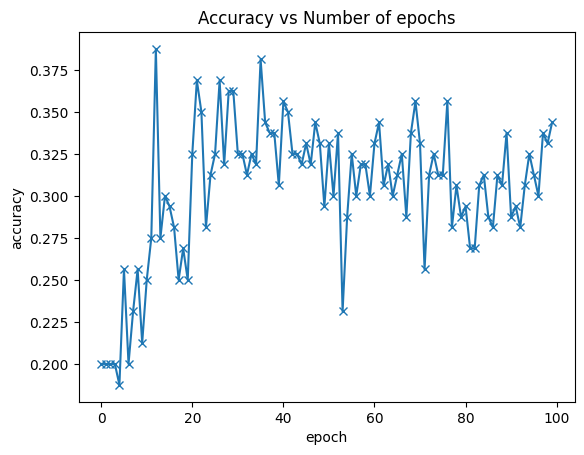

In [21]:
def plot_accuracies(history):
    accuracies = [x['validation_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs Number of epochs')

plot_accuracies(history)

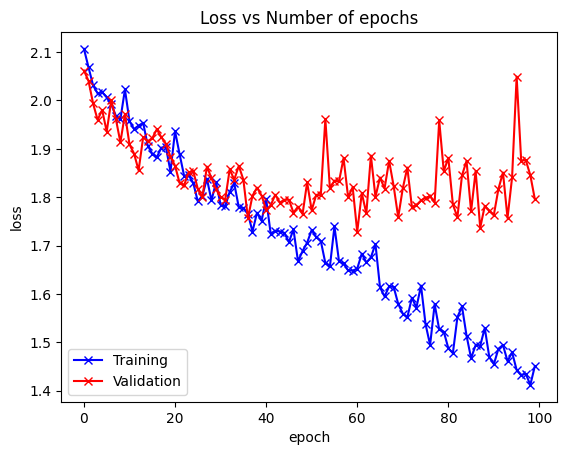

In [22]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['validation_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs Number of epochs')

plot_losses(history)

The model also seems to be overfitting as the training loss is getting lower but the validation loss is getting higher, and the dropout value helped a little bit but not much for solving the overfitting issue. It's better than `dropout_rate = 0.1` though.

If we take the point `Epoch [35/100], Training Loss: 1.7779, Validation Loss: 1.8362, Validation Accuracy: 0.3812` as the point where validation loss goes higher while training loss drops by looking at Loss vs Number of Epochs plot, then our accuracy can be considered as `38%`

In [17]:
evaluate(model, test_dataloader)

{'validation_loss': 1.952928900718689,
 'validation_accuracy': 0.29609376192092896}

**Test Accuracy**: 29%

In [ ]:
torch.save(model.state_dict(), 'dropout2.pth')

In [12]:
best_model = to_device(CNNModel(), device)
best_model.load_state_dict(torch.load('dropout2.pth'))

<All keys matched successfully>

In [21]:
from sklearn.metrics import confusion_matrix

def get_all_preds(model, loader, device):
    all_preds = torch.tensor([], dtype=torch.long).to(device)
    for batch in loader:
        images, labels = batch
        images = to_device(images, device)
        preds = model(images)
        all_preds = torch.cat((all_preds, preds.argmax(dim=1)), dim=0)
    return all_preds

with torch.no_grad():
    all_preds = get_all_preds(best_model, test_dataloader, device)
    all_labels = torch.tensor([test_dataloader.dataloader.dataset.dataset.targets[i] for i in test_dataloader.dataloader.dataset.indices], dtype=torch.long)

cm = confusion_matrix(all_labels.numpy(), all_preds.cpu().numpy())


Confusion Matrix (Normalized)


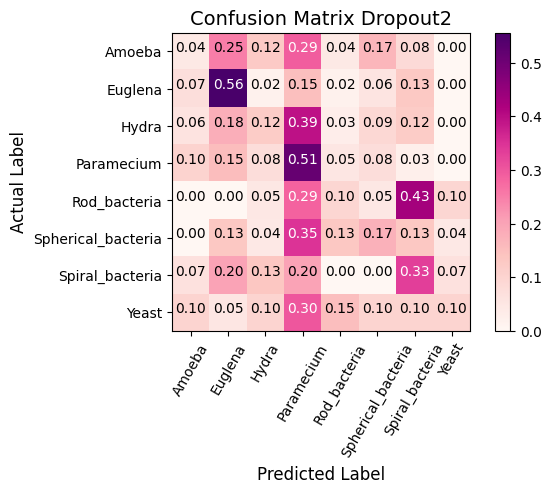

In [53]:
import matplotlib.pyplot as plt
import itertools
import numpy as np

def normalize_cm(cm: np.ndarray) -> np.ndarray:
    print("Confusion Matrix (Normalized)")
    return cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

def plot_matrix(cm, classes, cmap, title, font_size):
    tick_marks = np.arange(len(classes))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title, fontsize=font_size + 4)
    plt.colorbar()
    plt.xticks(tick_marks, classes, rotation=60)
    plt.yticks(tick_marks, classes)


def confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix Dropout2", cmap=plt.cm.RdPu):
    cm = normalize_cm(cm)

    font_size = 10
    plot_matrix(cm, classes, cmap, title, font_size)

    if normalize:
        fmt = ".2f"
    else:
        fmt = "d"

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i, format(cm[i, j], fmt), 
            horizontalalignment="center", 
            color="white" if cm[i, j] > thresh else "black", 
            size="medium"
        )

    plt.tight_layout()
    plt.ylabel("Actual Label", fontsize=font_size + 2)
    plt.xlabel("Predicted Label", fontsize=font_size + 2)

microorganism_types = ["Amoeba", "Euglena", "Hydra", "Paramecium", "Rod_bacteria", "Spherical_bacteria", "Spiral_bacteria", "Yeast"]
confusion_matrix(cm, classes=microorganism_types , normalize=True)
plt.show()
